## Grandient Boosting Modeling for Reading ##

The models are:
- CatBoost
- XGBoost
- LightGBM
- HistGradientBoosting

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

import warnings 
warnings.filterwarnings('ignore')

# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score

### Prepare data ###

Loading the data cleaned from [Data_Integration.ipynb](../processing/Data_Integration.ipynb) and [EDA.ipynb](../processing/EDA.ipynb)

In [3]:
df = pd.read_csv('../processing/DATA_Texas_District_v5.csv', sep=',', header=0)
print(df.shape)

(979, 126)


**Get dummies for categorical feature `Locale`**

In [4]:
df = pd.get_dummies(df, columns=['Locale'], prefix='Locale')
print(df.shape)

(979, 137)


**Split data**

In [5]:
labels = ['Label_Math', 'Label_Reading', 'Label_All']
cols_drop = ['% Students Tested Math - Grade 3 2018-2019',
            '% Students Tested Math - Grade 4 2018-2019',
            '% Students Tested Math - Grade 5 2018-2019',
            '% Students Tested Math - Grade 6 2018-2019',
            '% Students Tested Math - Grade 7 2018-2019',
            '% Students Tested Math - Grade 8 2018-2019',
            '% Students Tested Math - Grade 3 2020-2021',
            '% Students Tested Math - Grade 4 2020-2021',
            '% Students Tested Math - Grade 5 2020-2021',
            '% Students Tested Math - Grade 6 2020-2021',
            '% Students Tested Math - Grade 7 2020-2021',
            '% Students Tested Math - Grade 8 2020-2021',
            'Average Score Math All Grade 3 2018-2019',
            'Average Score Math All Grade 4 2018-2019',
            'Average Score Math All Grade 5 2018-2019',
            'Average Score Math All Grade 6 2018-2019',
            'Average Score Math All Grade 7 2018-2019',
            'Average Score Math All Grade 8 2018-2019',
            'District #', 'County #']

df['Label'] = df['Label_Reading'].apply(lambda x: 0 if x == -1
                                             else 1 if x == 0
                                             else 2)

y = df['Label'].values
X = df.drop(columns=labels + cols_drop + ['Label']).copy()
columns = df.drop(columns=labels + cols_drop + ['Label']).columns.to_list()
categorical_cols = [c for c in columns if 'Locale' in c]
categorical_cols_idx = [columns.index(c) for c in columns if 'Locale' in c]
numerical_cols = [c for c in columns if c not in categorical_cols]

random_state=123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=random_state, shuffle=True)
print(X.shape)

(979, 114)


In [6]:
values, counts = np.unique(y_train, return_counts=True)
values_test, counts_test = np.unique(y_test, return_counts=True)
pd.DataFrame({'Label': values.tolist(), 'Train': counts.tolist(), 'Test': counts_test.tolist()})

,Label,Train,Test
0,0,180,45
1,1,416,104
2,2,187,47


**Normalization**

In [7]:
# scaler = StandardScaler()

# scaler.fit(X_train[numerical_cols])
# X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
# X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

### Experiment with the Feature Sets selected from [Feature_Selection_Reading.ipynb](../processing/Feature_Selection_Reading.ipynb) ###

In [8]:
feature_selected = pd.read_csv('../Processing/Feature_Selection_Reading_Results.csv', sep=',', header=0)
feature_selected = feature_selected[feature_selected['selected']==1]
methods = feature_selected.Method.unique().tolist() + ["No Reduction"]

for n, m in enumerate(methods):
    n_feat = len(columns) if m == "No Reduction" else feature_selected[feature_selected['Method']==m].shape[0]
    print('Feature Set {}: n={} from {}'.format(n+1, n_feat, m))

Feature Set 1: n=13 from Variance Threshold
Feature Set 2: n=56 from Regularization - Lasso
Feature Set 3: n=57 from Feature Importance - Random Forest
Feature Set 4: n=36 from Permutation Importance - Random Forest
Feature Set 5: n=64 from Permutation Importance - Ridge
Feature Set 6: n=1 from RFE - Ridge
Feature Set 7: n=84 from RFE - Random Forest
Feature Set 8: n=57 from SFS - KNN
Feature Set 9: n=57 from SFS - Ridge
Feature Set 10: n=114 from No Reduction


**n iteration for models**

In [9]:
def get_n_iter (param_grid):
    n_iter_ratio = 0.2
    n_iter = 1
    for v in param_grid.values(): n_iter*=len(v)
    n_iter *= n_iter_ratio

    return int(n_iter)

### Modeling ###

In [10]:
rounds = 20

In [11]:
def model_report(estimator, param_grid, name, fit_params):
    result = pd.DataFrame()
    avg = 'weighted'
    cv=5
    
    n_iter=get_n_iter(param_grid)
    print('{} n_iter: {:0.0f}'.format(name, n_iter))     
    if name == 'CatBoost': n_iter=100
        
    for method in methods:
        features = columns if method == "No Reduction" else feature_selected[feature_selected['Method']==method]['feature'].unique().tolist()
                 
        X_train2 = X_train.loc[:, features].copy()
        X_test2 = X_test.loc[:, features].copy()        
                
        categorical_cols_inx=[features.index(f) for f in features if f in categorical_cols]
        if len(categorical_cols_inx) > 0:
            if (name == 'LightGBM'): fit_params['categorical_feature']=categorical_cols_inx
            if (name == 'CatBoost'): fit_params['cat_features']=categorical_cols_inx
            if (name == 'HistGB'): estimator.set_params(**{'categorical_features': categorical_cols_inx})
            if (name == 'XGBoost'):
                X_train2=X_train2.astype({features[c]: 'category' for c in categorical_cols_inx})
                X_test2=X_test2.astype({features[c]: 'category' for c in categorical_cols_inx})
        else: 
            if (name == 'LightGBM'): fit_params['categorical_feature']=None
            if (name == 'CatBoost'): fit_params['cat_features']=None
            if (name == 'HistGB'): estimator.set_params(**{'categorical_features': None})

        grid = RandomizedSearchCV(estimator, param_distributions=param_grid, cv=cv, n_jobs=-1, 
                              random_state=random_state, n_iter=n_iter)

        start_cpu = time.process_time()
        start_wall = time.time()
        
        if name == 'HistGB': 
            grid.fit(X_train2, y_train)
        elif name == 'LightGBM':
            fit_params['eval_set'] =  [(X_test2.values, y_test)]
            grid.fit(X_train2.values, y_train, **fit_params)
        else:
            fit_params['eval_set'] =  [(X_test2, y_test)]
            grid.fit(X_train2, y_train, **fit_params)            
       
        if name == 'XGBoost': grid.best_estimator_.save_model("categorical-model.json")
            
        cpu_time = time.process_time() - start_cpu
        wall_time = time.time() - start_wall
        y_pred = grid.best_estimator_.predict(X_test2)
        
        temp = {'Model': name,
                'n Selected': len(features),
                'Method': method,
                'best_params': grid.best_params_,
                'Best Accuracy': grid.best_score_, 
                'Train Accuracy': grid.best_estimator_.score(X_train2, y_train),
                'Test Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred, average=avg),
                'Recall': recall_score(y_test, y_pred, average=avg),
                'MCC': matthews_corrcoef(y_test, y_pred), 
                'F1': f1_score(y_test, y_pred, average=avg),
#                 'ROC': roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test2), multi_class='ovr', average=avg),
                'conf_mat': confusion_matrix(y_test, y_pred), 
                'Prediction': y_pred,
                'predict_proba': grid.best_estimator_.predict_proba(X_test2),
                'Features': features,
                'estimator': grid.best_estimator_,
                'classification_report': classification_report(y_test, y_pred),
                'Train Time CPU': cpu_time,
                'Train Time Wall': wall_time,
                'n_iter': n_iter}
        result = pd.concat([result, pd.DataFrame([temp])], ignore_index=True)
    return result

In [12]:
results = pd.DataFrame()

**CatBoost**

In [13]:
%%time
from catboost import CatBoostClassifier

params = {'iterations': [50, 100, 200],
        'depth': [3, 6, 9],
        'min_data_in_leaf': [1, 5, 10],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'l2_leaf_reg': [0, 0.01, 0.1, 1, 10],
        'random_strength': [0, 5, 10, 15]}

fit_params = {'early_stopping_rounds': rounds}

estimator = CatBoostClassifier(random_seed=random_state, verbose=False, 
                               loss_function='MultiClass', eval_metric="MultiClass", one_hot_max_size=4, border_count=254)
                               
result_report=model_report(estimator, params, 'CatBoost', fit_params)
results=pd.concat([results, result_report], ignore_index=True)

CatBoost n_iter: 432
CPU times: total: 3min 43s
Wall time: 2h 34min 20s


**XGBoost**

In [14]:
%%time
import xgboost

params = {'n_estimators': [50, 100, 200],
'max_depth': [1, 6, 0],
'min_child_weight': [0, 0.001, 0.1, 1],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'alpha': [0,  0.1, 10],
'lambda': [0,  0.1, 10],
'gamma': [0,  0.1, 10]}

estimator = xgboost.XGBClassifier(seed=random_state, objective='multi:softproba', eval_metric='mlogloss', use_label_encoder=False, verbosity=0,
                                  num_class=3, tree_method="hist", early_stopping_rounds=rounds, enable_categorical=True, max_cat_to_onehot=4)

result_report=model_report(estimator, params, 'XGBoost', {})
results=pd.concat([results, result_report], ignore_index=True)

XGBoost n_iter: 777
[0]	validation_0-mlogloss:1.09631
[1]	validation_0-mlogloss:1.09405
[2]	validation_0-mlogloss:1.09181
[3]	validation_0-mlogloss:1.08961
[4]	validation_0-mlogloss:1.08743
[5]	validation_0-mlogloss:1.08529
[6]	validation_0-mlogloss:1.08317
[7]	validation_0-mlogloss:1.08108
[8]	validation_0-mlogloss:1.07902
[9]	validation_0-mlogloss:1.07713
[10]	validation_0-mlogloss:1.07526
[11]	validation_0-mlogloss:1.07342
[12]	validation_0-mlogloss:1.07161
[13]	validation_0-mlogloss:1.06967
[14]	validation_0-mlogloss:1.06790
[15]	validation_0-mlogloss:1.06616
[16]	validation_0-mlogloss:1.06443
[17]	validation_0-mlogloss:1.06259
[18]	validation_0-mlogloss:1.06091
[19]	validation_0-mlogloss:1.05926
[20]	validation_0-mlogloss:1.05762
[21]	validation_0-mlogloss:1.05587
[22]	validation_0-mlogloss:1.05428
[23]	validation_0-mlogloss:1.05270
[24]	validation_0-mlogloss:1.05115
[25]	validation_0-mlogloss:1.04961
[26]	validation_0-mlogloss:1.04797
[27]	validation_0-mlogloss:1.04647
[28]	valid

[40]	validation_0-mlogloss:1.01056
[41]	validation_0-mlogloss:1.00895
[42]	validation_0-mlogloss:1.00741
[43]	validation_0-mlogloss:1.00590
[44]	validation_0-mlogloss:1.00440
[45]	validation_0-mlogloss:1.00289
[46]	validation_0-mlogloss:1.00140
[47]	validation_0-mlogloss:0.99994
[48]	validation_0-mlogloss:0.99848
[49]	validation_0-mlogloss:0.99710
[50]	validation_0-mlogloss:0.99566
[51]	validation_0-mlogloss:0.99432
[52]	validation_0-mlogloss:0.99288
[53]	validation_0-mlogloss:0.99153
[54]	validation_0-mlogloss:0.99021
[55]	validation_0-mlogloss:0.98886
[56]	validation_0-mlogloss:0.98754
[57]	validation_0-mlogloss:0.98613
[58]	validation_0-mlogloss:0.98488
[59]	validation_0-mlogloss:0.98361
[60]	validation_0-mlogloss:0.98231
[61]	validation_0-mlogloss:0.98106
[62]	validation_0-mlogloss:0.97972
[63]	validation_0-mlogloss:0.97853
[64]	validation_0-mlogloss:0.97730
[65]	validation_0-mlogloss:0.97606
[66]	validation_0-mlogloss:0.97492
[67]	validation_0-mlogloss:0.97378
[68]	validation_0-ml

[72]	validation_0-mlogloss:0.88044
[73]	validation_0-mlogloss:0.88038
[74]	validation_0-mlogloss:0.88031
[75]	validation_0-mlogloss:0.88022
[76]	validation_0-mlogloss:0.88017
[77]	validation_0-mlogloss:0.88011
[78]	validation_0-mlogloss:0.88001
[79]	validation_0-mlogloss:0.87993
[80]	validation_0-mlogloss:0.87988
[81]	validation_0-mlogloss:0.87981
[82]	validation_0-mlogloss:0.87977
[83]	validation_0-mlogloss:0.87968
[84]	validation_0-mlogloss:0.87963
[85]	validation_0-mlogloss:0.87959
[86]	validation_0-mlogloss:0.87954
[87]	validation_0-mlogloss:0.87950
[88]	validation_0-mlogloss:0.87946
[89]	validation_0-mlogloss:0.87941
[90]	validation_0-mlogloss:0.87938
[91]	validation_0-mlogloss:0.87936
[92]	validation_0-mlogloss:0.87928
[93]	validation_0-mlogloss:0.87925
[94]	validation_0-mlogloss:0.87923
[95]	validation_0-mlogloss:0.87919
[96]	validation_0-mlogloss:0.87916
[97]	validation_0-mlogloss:0.87911
[98]	validation_0-mlogloss:0.87908
[99]	validation_0-mlogloss:0.87906
[0]	validation_0-mlo

[2]	validation_0-mlogloss:1.02442
[3]	validation_0-mlogloss:1.00666
[4]	validation_0-mlogloss:0.99025
[5]	validation_0-mlogloss:0.97661
[6]	validation_0-mlogloss:0.96659
[7]	validation_0-mlogloss:0.95597
[8]	validation_0-mlogloss:0.94780
[9]	validation_0-mlogloss:0.94051
[10]	validation_0-mlogloss:0.93377
[11]	validation_0-mlogloss:0.92721
[12]	validation_0-mlogloss:0.92166
[13]	validation_0-mlogloss:0.91647
[14]	validation_0-mlogloss:0.91268
[15]	validation_0-mlogloss:0.90930
[16]	validation_0-mlogloss:0.90620
[17]	validation_0-mlogloss:0.90297
[18]	validation_0-mlogloss:0.90101
[19]	validation_0-mlogloss:0.89808
[20]	validation_0-mlogloss:0.89680
[21]	validation_0-mlogloss:0.89461
[22]	validation_0-mlogloss:0.89298
[23]	validation_0-mlogloss:0.89091
[24]	validation_0-mlogloss:0.88861
[25]	validation_0-mlogloss:0.88701
[26]	validation_0-mlogloss:0.88558
[27]	validation_0-mlogloss:0.88365
[28]	validation_0-mlogloss:0.88233
[29]	validation_0-mlogloss:0.88038
[30]	validation_0-mlogloss:0

**LightGBM**

In [15]:
%%time
import lightgbm as lgb

params = {'n_estimators': [50, 100, 200],
'max_depth': [1, 6, -1],
'min_sum_hessian_in_leaf': [0, 0.001, 0.1, 1],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'reg_alpha': [0,  0.1, 10],
'reg_lambda': [0,  0.1, 10],
'min_split_gain': [0,  0.1, 10]}

fit_params = {'early_stopping_rounds': rounds}

estimator = lgb.LGBMClassifier(random_state=random_state, objective="multiclass", metric="multi_logloss", verbosity=-1, silent=True, force_col_wise=True,
                               num_class=3, is_unbalance=True, max_cat_threshold=32)
                               
result_report=model_report(estimator, params, 'LightGBM', fit_params)
results=pd.concat([results, result_report], ignore_index=True)

LightGBM n_iter: 777
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[1]	valid_0's multi_logloss: 0.991538
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.971228
[3]	valid_0's multi_logloss: 0.95586
[4]	valid_0's multi_logloss: 0.945729
[5]	valid_0's multi_logloss: 0.937658
[6]	valid_0's multi_logloss: 0.928555
[7]	valid_0's multi_logloss: 0.921892
[8]	valid_0's multi_logloss: 0.917384
[9]	valid_0's multi_logloss: 0.912774
[10]	valid_0's multi_logloss: 0.907945
[11]	valid_0's multi_logloss: 0.904319
[12]	valid_0's multi_logloss: 0.900376
[13]	valid_0's multi_logloss: 0.899944
[14]	valid_0's multi_logloss: 0.89786
[15]	valid_0's multi_logloss: 0.897773
[16]	valid_0's multi_logloss: 0.896734
[17]	valid_0's multi_logloss: 0.898126
[18]	valid_0's multi_logloss: 0.898639
[19]	valid_0's multi_logloss: 0.89867
[20]	valid_0's multi_logloss: 0.898388
[21]	valid_0's

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[1]	valid_0's multi_logloss: 0.992896
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.974343
[3]	valid_0's multi_logloss: 0.959441
[4]	valid_0's multi_logloss: 0.947052
[5]	valid_0's multi_logloss: 0.936839
[6]	valid_0's multi_logloss: 0.928396
[7]	valid_0's multi_logloss: 0.921359
[8]	valid_0's multi_logloss: 0.915621
[9]	valid_0's multi_logloss: 0.911116
[10]	valid_0's multi_logloss: 0.906559
[11]	valid_0's multi_logloss: 0.903285
[12]	valid_0's multi_logloss: 0.899491
[13]	valid_0's multi_logloss: 0.895788
[14]	valid_0's multi_logloss: 0.893962
[15]	valid_0's multi_logloss: 0.89145
[16]	valid_0's multi_logloss: 0.890256
[17]	valid_0's multi_logloss: 0.889233
[18]	valid_0's multi_logloss: 0.888298
[19]	valid_0's multi_logloss: 0.886554
[20]	valid_0's multi_logloss: 0.88596
[21]	valid_0's multi_loglo

**HistGradientBoosting**

In [16]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier

params = {'max_iter': [50, 100, 200],
'max_depth': [1, 6, None],
'max_leaf_nodes': [10, 31, 50, 64],
'min_samples_leaf': [10, 20, 30],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'l2_regularization': [0, 0.01, 0.1, 1, 10]}

estimator=HistGradientBoostingClassifier(random_state=random_state, n_iter_no_change=rounds, early_stopping=True)
result_report=model_report(estimator, params, 'HistGB', {})
results=pd.concat([results, result_report], ignore_index=True)

HistGB n_iter: 432
CPU times: total: 1min 24s
Wall time: 14min 2s


## Result ##

In [17]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)[['Model', 'Method', 'n Selected', 'Test Accuracy', 'MCC', 'F1', 'best_params']]

,Model,Method,n Selected,Test Accuracy,MCC,F1,best_params
8,CatBoost,SFS - Ridge,57,0.642857,0.379836,0.594501,"{'random_strength': 0, 'min_data_in_leaf': 5, ..."
9,CatBoost,No Reduction,114,0.627551,0.357073,0.553646,"{'random_strength': 0, 'min_data_in_leaf': 10,..."
37,HistGB,SFS - KNN,57,0.627551,0.349232,0.569227,"{'min_samples_leaf': 30, 'max_leaf_nodes': 10,..."
26,LightGBM,RFE - Random Forest,84,0.627551,0.344129,0.586465,"{'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estima..."
19,XGBoost,No Reduction,114,0.622449,0.334013,0.576184,"{'n_estimators': 100, 'min_child_weight': 1, '..."
11,XGBoost,Regularization - Lasso,56,0.622449,0.333685,0.576399,"{'n_estimators': 100, 'min_child_weight': 0, '..."
4,CatBoost,Permutation Importance - Ridge,64,0.617347,0.326293,0.552452,"{'random_strength': 0, 'min_data_in_leaf': 10,..."
6,CatBoost,RFE - Random Forest,84,0.617347,0.325309,0.560003,"{'random_strength': 0, 'min_data_in_leaf': 1, ..."
27,LightGBM,SFS - KNN,57,0.617347,0.324444,0.567061,"{'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimat..."
18,XGBoost,SFS - Ridge,57,0.612245,0.318736,0.528581,"{'n_estimators': 50, 'min_child_weight': 1, 'm..."


In [18]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)['Model'].value_counts().to_frame()

,Model
CatBoost,4
XGBoost,3
LightGBM,2
HistGB,1


In [19]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)['n Selected'].value_counts().sort_index().to_frame()

,n Selected
56,1
57,4
64,1
84,2
114,2


**Accuracy, MCC and F1 Score**

In [20]:
results2 = pd.DataFrame()
for col in ['Train Accuracy', 'Test Accuracy', 'MCC', 'F1']:
    temp = results[['Model', 'n Selected'] + [col]].copy()
    temp['Score'] = col
    temp.rename(columns={col: 'Score value'}, inplace=True)
    results2 = pd.concat([results2, temp], ignore_index=True)
results2=results2.astype({'n Selected': 'int32'})

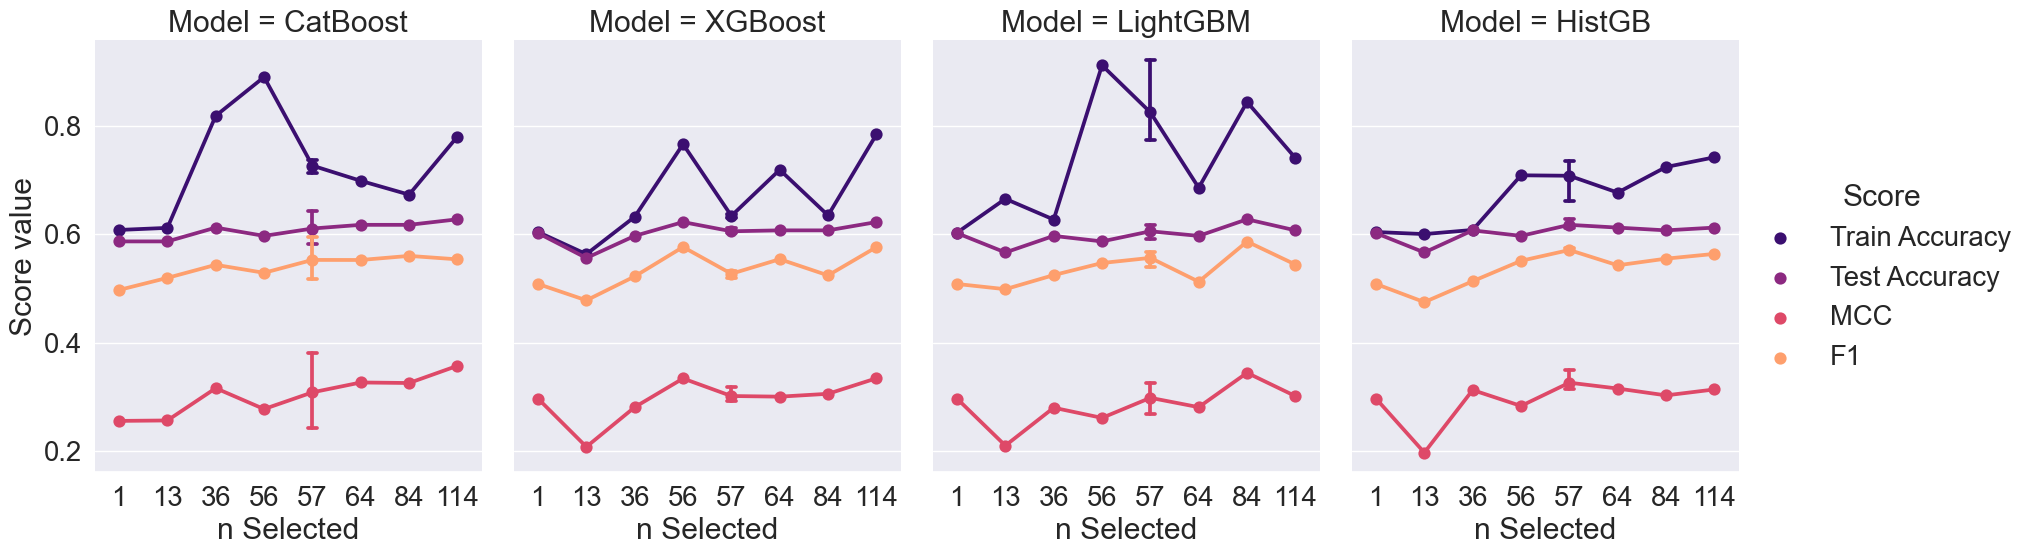

In [21]:
sns.set(rc={'figure.figsize':(20,20)})
sns.set_theme(style='whitegrid')
sns.set(font_scale=1.8)

g = sns.catplot(x="n Selected", y="Score value", hue="Score", col="Model",
                capsize=.2, palette="magma", height=6, aspect=.75,
                kind="point", data=results2)
g.despine(left=True)
plt.show()

In [22]:
models = results['Model'].unique().tolist()
temp=results.sort_values(by=['Model', 'MCC', 'F1'], ascending=False)

best_per_model_idx = []
for i in range(len(temp.index)):
    if i % (n+1) == 0: best_per_model_idx.append(temp.index[i])

**Confusion Matrix**

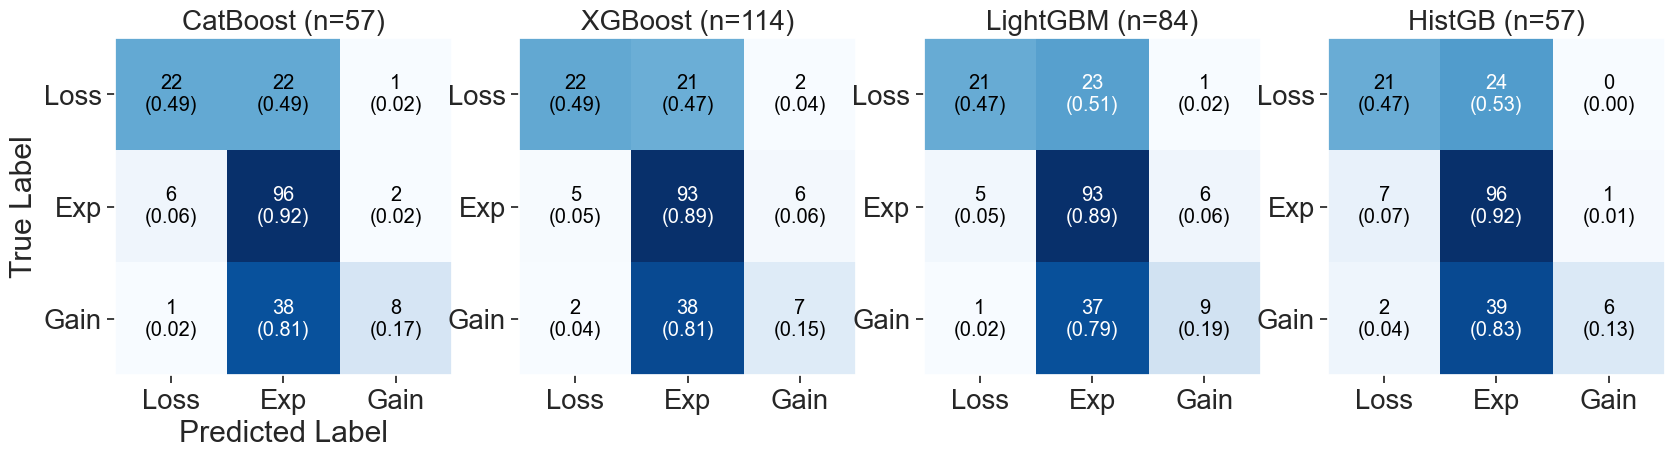

In [23]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.ticker as mticker

def ticks(x, position):
    if position == 1: return 'Loss'
    if position == 2: return 'Exp'
    if position == 3: return 'Gain'
    
fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,10))
sns.set(font_scale=1.2)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    plot_confusion_matrix(axis=axes[i], conf_mat=results.loc[idx, 'conf_mat'],
                          show_absolute=True, show_normed=True)
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    if (i > 0): axes[i].set(xlabel='', ylabel='')
    else : axes[i].set(xlabel='Predicted Label', ylabel='True Label')
    axes[i].xaxis.set_major_formatter(mticker.FuncFormatter(ticks))
    axes[i].yaxis.set_major_formatter(mticker.FuncFormatter(ticks))
plt.show()

**ROC Curve**

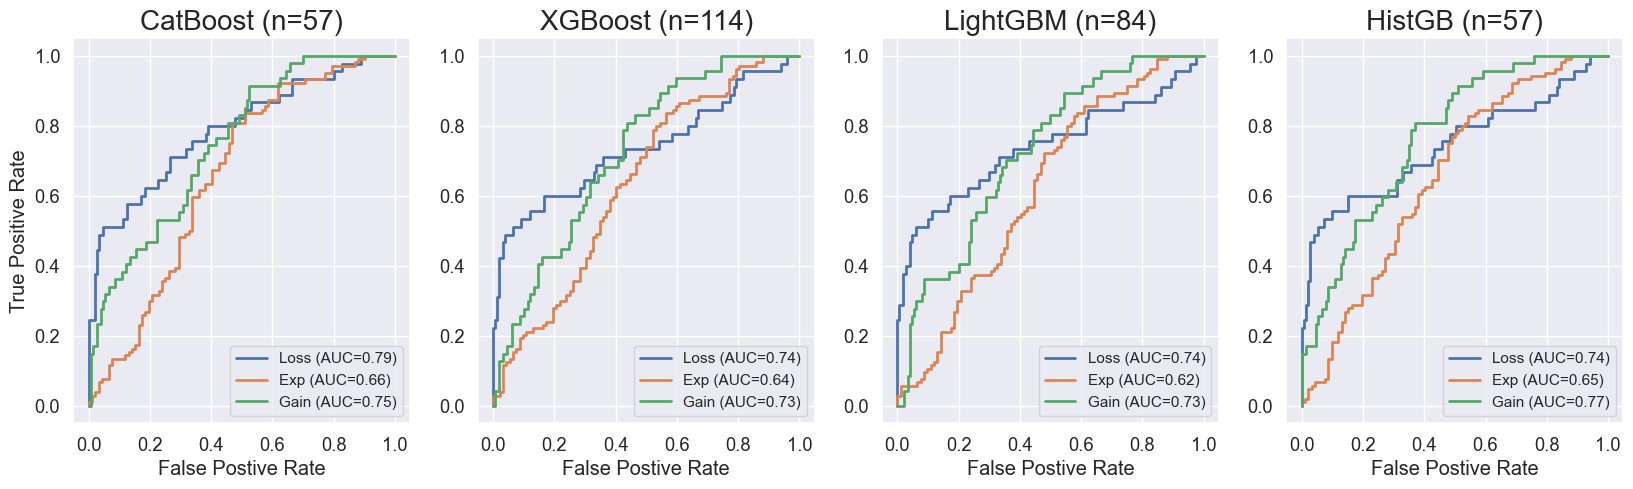

In [24]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

classes=[0, 1, 2]
y_test_bin=label_binarize(y_test, classes=classes)

fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,5))
sns.set(font_scale=1)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    fpr, tpr = {}, {}

    for c in classes:
        fpr[c], tpr[c], _ = roc_curve(y_test_bin[:, c], results.loc[idx, 'predict_proba'][:, c])
        axes[i].plot(fpr[c], tpr[c], lw=2, label='{} (AUC={:0.2f})'.format(ticks(c,c+1), auc(fpr[c], tpr[c])))
    
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    axes[i].set_xlabel("False Postive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[i].legend(loc="best")

plt.show()

**Precision-Recall Curve**

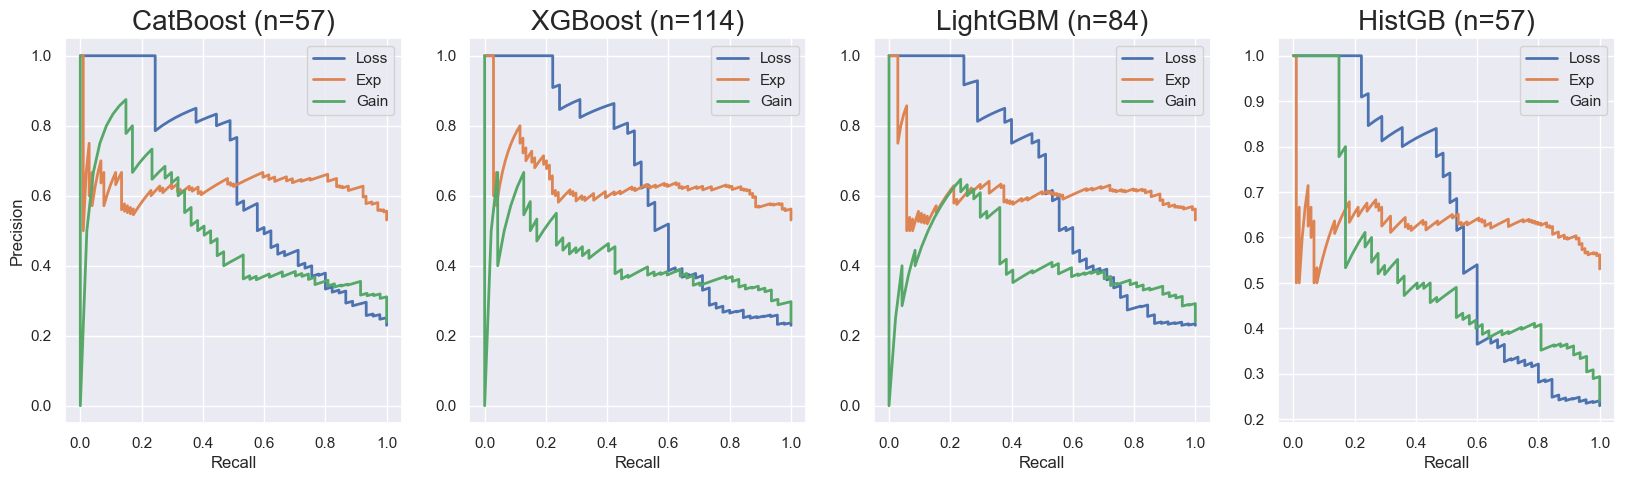

In [25]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve

classes=[0, 1, 2]
y_test_bin=label_binarize(y_test, classes=classes)

fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,5))
sns.set(font_scale=1)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    prec, rec = {}, {}

    for c in classes:
        prec[c], rec[c], _ = precision_recall_curve(y_test_bin[:, c], results.loc[idx, 'predict_proba'][:, c])
        axes[i].plot(rec[c], prec[c], lw=2, label='{}'.format(ticks(c,c+1)))
    
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    axes[i].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[i].legend(loc="best")

plt.show()

In [26]:
for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    print(title, '\n', results.loc[idx, 'classification_report'])

CatBoost (n=57) 
               precision    recall  f1-score   support

           0       0.76      0.49      0.59        45
           1       0.62      0.92      0.74       104
           2       0.73      0.17      0.28        47

    accuracy                           0.64       196
   macro avg       0.70      0.53      0.54       196
weighted avg       0.68      0.64      0.59       196

XGBoost (n=114) 
               precision    recall  f1-score   support

           0       0.76      0.49      0.59        45
           1       0.61      0.89      0.73       104
           2       0.47      0.15      0.23        47

    accuracy                           0.62       196
   macro avg       0.61      0.51      0.52       196
weighted avg       0.61      0.62      0.58       196

LightGBM (n=84) 
               precision    recall  f1-score   support

           0       0.78      0.47      0.58        45
           1       0.61      0.89      0.72       104
           2       0.

In [27]:
results.sort_values(by=['MCC'], ascending=False).to_csv('Modeling_GB_Reading.csv', index=False)